In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

### Analytical solution

In [27]:
def U_exact(X, T, kappa):
    return  np.sin(np.pi * X) * np.exp(-kappa * (np.pi**2) * T)

### Generater data points with noise for $\kappa = 0.1$

In [29]:
# Create grid
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Sample N_d data points
kappa = 0.1
N_d = 20
U = U_exact(X, T, kappa)
x_data = torch.rand(N_d, 1)
t_data = torch.rand(N_d, 1)
u_data = U_exact(x_data, t_data, kappa) + 0.01 * torch.randn_like(x_data)

### Visualize analytical solution and data points

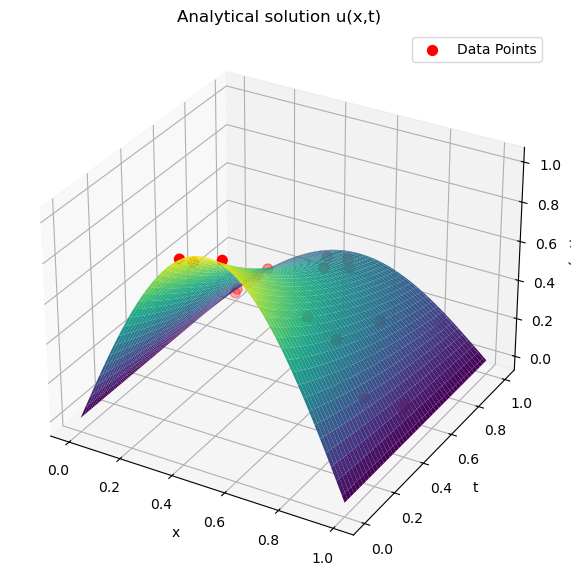

In [31]:
# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='viridis')
ax.scatter(x_data, t_data, u_data, color='red', s=50, label='Data Points')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Analytical solution u(x,t)')
ax.legend()
plt.show()

## Solve with PINN

## Neural Network

In [41]:
class PINNHeat(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # kappa as a learnable parameter
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.2)))
        
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1))

    def forward(self, x, t):
        
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

    @property
    def kappa(self):
        # ensure positivity
        return torch.exp(self.log_kappa)

### Residual loss / boundary condition loss / data loss

In [42]:
def residual_loss(model, x, t):
    
    x = x.detach().requires_grad_(True)
    t = t.detach().requires_grad_(True)
    
    u = model(x, t)
    # Derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - model.kappa * u_xx
    loss_rs = torch.mean(residual**2)
    
    return loss_rs

def boundary_loss(model, x_bc_all, t_bc_all, u_bc_all):
    
    u_pred_bc = model(x_bc_all, t_bc_all)
    loss_bc = torch.mean((u_pred_bc - u_bc_all)**2)

    return loss_bc

def data_loss(model, x_data, t_data, u_data):
    
    u_pred_data = model(x_data, t_data)
    loss_data = torch.mean((u_pred_data - u_data)**2)

    return loss_data

### Training loop

In [46]:
def train_PINN_heat(model, epochs, lr=1e-3, λ_data=1.0):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Store loss
    loss_history = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        # PDE residual loss
        loss_pde = residual_loss(model, x_r, t_r)

        # Boundary & initial condition loss
        loss_bc = boundary_loss(model, x_bc_all, t_bc_all, u_bc_all)
        
        # Data loss
        loss_data = data_loss(model, x_data, t_data, u_data)

        # Total loss
        loss = loss_pde + λ_data * loss_data + loss_bc
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch+1) % 500 == 0:
            print(f"Epoch {epoch+1}: total_loss={loss.item():.3e}  "
                  f"κ={model.kappa.item():.3f}")

    return model, loss_history

### Define domain and boundary conditions

In [47]:
# Time and collocation points
T = 1.0
N_r = 5000

# Collocation points for physics loss
x_r = torch.rand(N_r, 1)
t_r = torch.rand(N_r, 1) * T

# Boundary condition
N_bc = 50
t_bc = torch.linspace(0, T, N_bc).unsqueeze(1)
x_bc_left  = torch.zeros_like(t_bc)
x_bc_right = torch.ones_like(t_bc)
u_bc = torch.zeros_like(t_bc)   # both boundaries = 0

# Initial condition
N_ic = 50
x_ic = torch.linspace(0, 1, N_ic).unsqueeze(1)
t_ic = torch.zeros_like(x_ic)
u_ic = torch.sin(np.pi * x_ic)

# Pack boundary & initial tensors
x_bc_all = torch.cat([x_bc_left, x_bc_right, x_ic], dim=0)
t_bc_all = torch.cat([t_bc,     t_bc,       t_ic], dim=0)
u_bc_all = torch.cat([u_bc,     u_bc,       u_ic], dim=0)

### Train model

In [48]:
# Initialize the PINN model
model = PINNHeat()

# Epochs
epochs = 1500

# Training
trained_model, loss_history = train_PINN_heat(model, epochs, lr=1e-3, λ_data=10.0)

Epoch 500: total_loss=7.001e-02  κ=0.190
Epoch 1000: total_loss=7.308e-03  κ=0.122
Epoch 1500: total_loss=1.331e-03  κ=0.105


### Loss plot

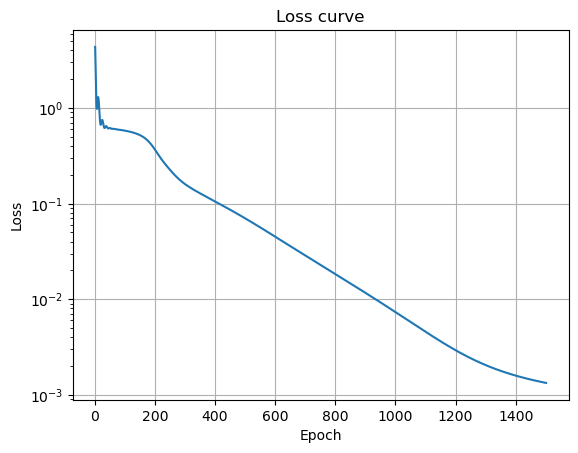

In [49]:
epoch_x = np.linspace(1, epochs+1, epochs)
plt.plot(epoch_x, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.grid()
plt.yscale('log')
plt.show()

### Visualization

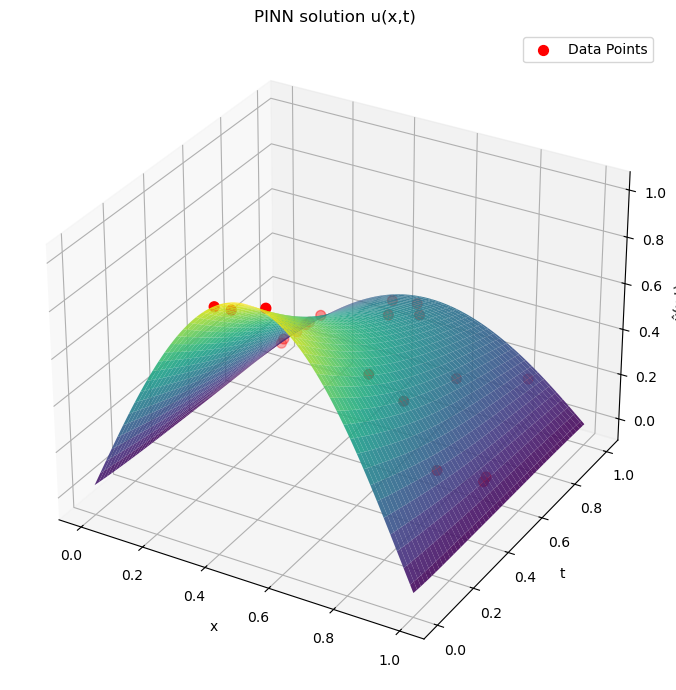

In [54]:
# Create grid
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Flatten and convert to torch tensors
x_flat = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
t_flat = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)

# Predict u(x,t) using trained model
with torch.no_grad():
    U_pred = trained_model(x_flat, t_flat).cpu().numpy().reshape(100, 100)

# Plot surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_pred, cmap='viridis', alpha=0.9)
ax.scatter(x_data, t_data, u_data, color='red', s=50, label='Data Points')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('û(x,t)')
ax.set_title('PINN solution u(x,t)')
ax.legend()
plt.tight_layout()
plt.show()